https://www.kaggle.com/datasets/harishkumardatalab/medical-insurance-price-prediction Набор представляет собой данные о мед страховке.
Пример цели: Рассчитать стоимость будущей страховки
Входные данные: возраст, пол, индекс массы тела, дети, курит ли, регион, стоимость

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv(".//static//csv//Medical_insurance.csv")
print(df.columns)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


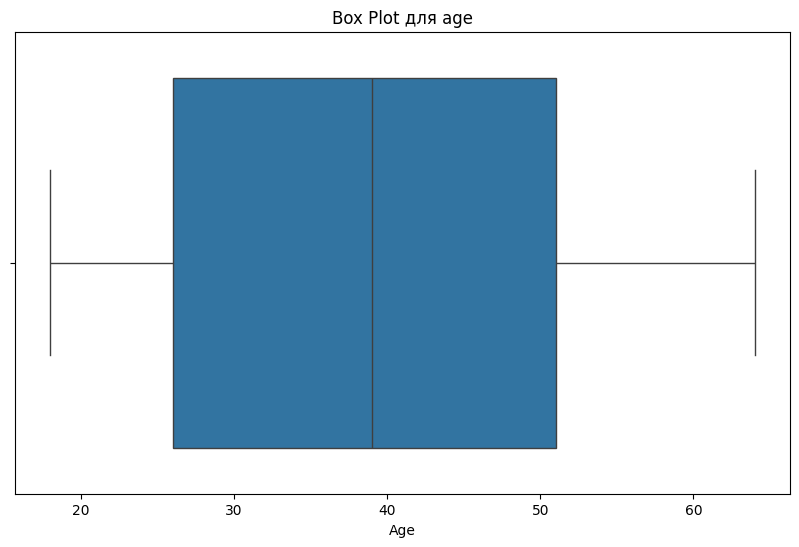

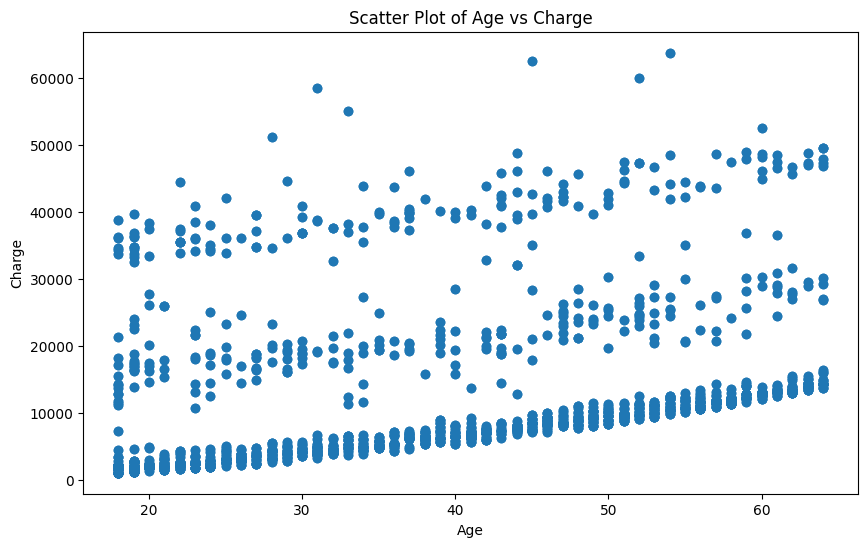

In [109]:
# Визуализация данных - ящик с усами. Как видим - выборка относительно сбалансированна, пускай и смещена в меньшую сторону. Пустых значений нет.
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["age"])
plt.title("Box Plot для age")
plt.xlabel("Age")
plt.show()

#Визуализируем отношение стоимости и возраста
plt.figure(figsize=(10, 6))
plt.scatter(df["age"], df["charges"])
plt.xlabel('Age')
plt.ylabel("Charge")
plt.title('Scatter Plot of Age vs Charge')
plt.show()

Выбросы:
      age     sex    bmi  children smoker     region     charges
14     27    male  42.13         0    yes  southeast  39611.7577
19     30    male  35.30         0    yes  southwest  36837.4670
23     34  female  31.92         1    yes  northeast  37701.8768
29     31    male  36.30         2    yes  southwest  38711.0000
30     22    male  35.60         0    yes  southwest  35585.5760
...   ...     ...    ...       ...    ...        ...         ...
2735   52    male  41.80         2    yes  southeast  47269.8540
2736   64    male  36.96         2    yes  southeast  49577.6624
2744   32    male  33.63         1    yes  northeast  37607.5277
2764   22  female  31.02         3    yes  southeast  35595.5898
2765   47    male  36.08         1    yes  southeast  42211.1382

[296 rows x 7 columns]


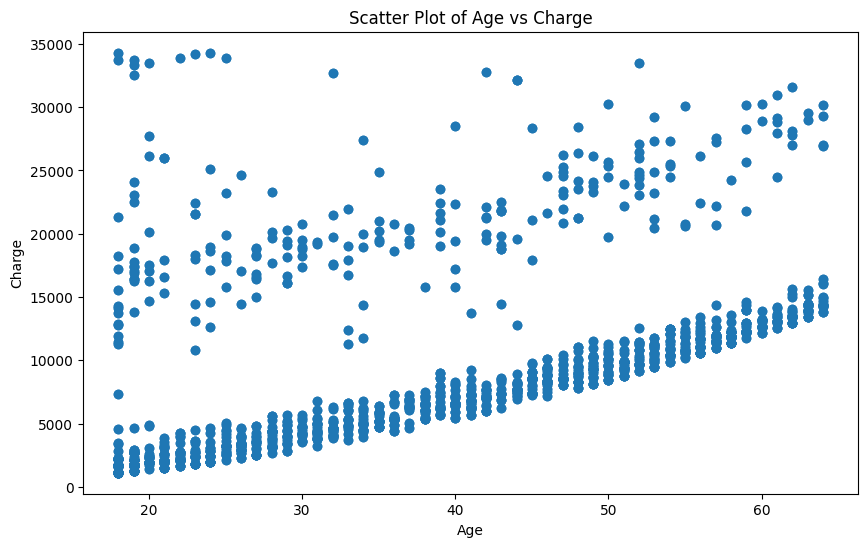

In [110]:
# Есть шумы, убираем


# Статистический анализ для определения выбросов
Q1 = df["charges"].quantile(0.25)
Q3 = df["charges"].quantile(0.75)
IQR = Q3 - Q1

# Определение порога для выбросов
threshold = 1.5 * IQR
outliers = (df["charges"] < (Q1 - threshold)) | (df["charges"] > (Q3 + threshold))

# Вывод выбросов
print("Выбросы:")
print(df[outliers])

# Обработка выбросов
# В данном случае мы заменим выбросы на медианное значение
median_charge = df["charges"].median()
df.loc[outliers, "charges"] = 0
df = df[df.charges != 0]

# Визуализация данных после обработки
plt.figure(figsize=(10, 6))
plt.scatter(df["age"], df["charges"])
plt.xlabel("Age")
plt.ylabel("Charge")
plt.title("Scatter Plot of Age vs Charge")
plt.show()

Теперь создадим выборки.

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)

# Разделение остатка на контрольную и тестовую выборки
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Проверка размеров выборок
print("Размер обучающей выборки:", len(train_df))
print("Размер контрольной выборки:", len(val_df))
print("Размер тестовой выборки:", len(test_df))

# Сохранение выборок в файлы
train_df.to_csv(".//static//csv//train_data.csv", index=False)
val_df.to_csv(".//static//csv//val_data.csv", index=False)
test_df.to_csv(".//static//csv//test_data.csv", index=False)

Размер обучающей выборки: 1485
Размер контрольной выборки: 495
Размер тестовой выборки: 496


Проанализируем сбалансированность выборок

In [112]:
train_df = pd.read_csv(".//static//csv//train_data.csv")
val_df = pd.read_csv(".//static//csv//val_data.csv")
test_df = pd.read_csv(".//static//csv//test_data.csv")

# Оценка сбалансированности
def check_balance(df, name):
    counts = df['sex'].value_counts()
    print(f"Распределение Review_type в {name}:")
    print(counts)
    print(f"Процент мужчин: {counts['male'] / len(df) * 100:.2f}%")
    print(f"Процент женщин: {counts['female'] / len(df) * 100:.2f}%")
    print()

# Определение необходимости аугментации данных
def need_augmentation(df):
    counts = df['sex'].value_counts()
    ratio = counts['male'] / counts['female']
    if ratio > 1.5 or ratio < 0.67:
        print("Необходима аугментация данных для балансировки классов.")
    else:
        print("Аугментация данных не требуется.")
        
check_balance(train_df, "обучающей выборке")
check_balance(val_df, "контрольной выборке")
check_balance(test_df, "тестовой выборке")



need_augmentation(train_df)
need_augmentation(val_df)
need_augmentation(test_df)

Распределение Review_type в обучающей выборке:
sex
female    765
male      720
Name: count, dtype: int64
Процент мужчин: 48.48%
Процент женщин: 51.52%

Распределение Review_type в контрольной выборке:
sex
male      257
female    238
Name: count, dtype: int64
Процент мужчин: 51.92%
Процент женщин: 48.08%

Распределение Review_type в тестовой выборке:
sex
female    259
male      237
Name: count, dtype: int64
Процент мужчин: 47.78%
Процент женщин: 52.22%

Аугментация данных не требуется.
Аугментация данных не требуется.
Аугментация данных не требуется.


По результатам анализа требуется приращение, соотношения отзывов вне допустимого диапазона

In [113]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

# Загрузка данных
train_df = pd.read_csv(".//static//csv//train_data.csv")
val_df = pd.read_csv(".//static//csv//val_data.csv")
test_df = pd.read_csv(".//static//csv//test_data.csv")

# Преобразование категориальных признаков в числовые
def encode(df):
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        if column != 'sex':  # Пропускаем целевую переменную
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
            label_encoders[column] = le
    return label_encoders

# Преобразование целевой переменной в числовые значения
def encode_target(df):
    le = LabelEncoder()
    df['sex'] = le.fit_transform(df['sex'])
    return le

# Применение кодирования
label_encoders = encode(train_df)
encode(val_df)
encode(test_df)

# Кодирование целевой переменной
le_target = encode_target(train_df)
encode_target(val_df)
encode_target(test_df)

# Проверка типов данных
def check_data_types(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            print(f"Столбец '{column}' содержит строковые данные.")

check_data_types(train_df)
check_data_types(val_df)
check_data_types(test_df)

# Функция для выполнения oversampling
def oversample(df):
    if 'sex' not in df.columns:
        print("Столбец 'sex' отсутствует.")
        return df
    
    X = df.drop('sex', axis=1)
    y = df['sex']
    
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y) # type: ignore
    
    resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
    return resampled_df

# Функция для выполнения undersampling
def undersample(df):
    if 'sex' not in df.columns:
        print("Столбец 'sex' отсутствует.")
        return df
    
    X = df.drop('sex', axis=1)
    y = df['sex']
    
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y) # type: ignore
    
    resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
    return resampled_df

# Применение oversampling и undersampling к каждой выборке
train_df_oversampled = oversample(train_df)
val_df_oversampled = oversample(val_df)
test_df_oversampled = oversample(test_df)

train_df_undersampled = undersample(train_df)
val_df_undersampled = undersample(val_df)
test_df_undersampled = undersample(test_df)

# Обратное преобразование целевой переменной в строковые метки
def decode_target(df, le_target):
    df['sex'] = le_target.inverse_transform(df['sex'])

decode_target(train_df_oversampled, le_target)
decode_target(val_df_oversampled, le_target)
decode_target(test_df_oversampled, le_target)

decode_target(train_df_undersampled, le_target)
decode_target(val_df_undersampled, le_target)
decode_target(test_df_undersampled, le_target)

# Проверка результатов
def check_balance(df, name):
    if 'sex' not in df.columns:
        print(f"Столбец 'sex' отсутствует в {name}.")
        return
    
    counts = df['sex'].value_counts()
    print(f"Распределение sex в {name}:")
    print(counts)
    
    if 'male' in counts and 'female' in counts:
        print(f"Процент мужчин: {counts['male'] / len(df) * 100:.2f}%")
        print(f"Процент женщин: {counts['female'] / len(df) * 100:.2f}%")
    else:
        print("Отсутствуют один или оба класса (male/female.")
    print()

# Проверка сбалансированности после oversampling
print("Оверсэмплинг:")
check_balance(train_df_oversampled, "обучающей выборке")
check_balance(val_df_oversampled, "контрольной выборке")
check_balance(test_df_oversampled, "тестовой выборке")

# Проверка сбалансированности после undersampling
print("Андерсэмплинг:")
check_balance(train_df_undersampled, "обучающей выборке")
check_balance(val_df_undersampled, "контрольной выборке")
check_balance(test_df_undersampled, "тестовой выборке")

Оверсэмплинг:
Распределение sex в обучающей выборке:
sex
male      765
female    765
Name: count, dtype: int64
Процент мужчин: 50.00%
Процент женщин: 50.00%

Распределение sex в контрольной выборке:
sex
male      257
female    257
Name: count, dtype: int64
Процент мужчин: 50.00%
Процент женщин: 50.00%

Распределение sex в тестовой выборке:
sex
female    259
male      259
Name: count, dtype: int64
Процент мужчин: 50.00%
Процент женщин: 50.00%

Андерсэмплинг:
Распределение sex в обучающей выборке:
sex
female    720
male      720
Name: count, dtype: int64
Процент мужчин: 50.00%
Процент женщин: 50.00%

Распределение sex в контрольной выборке:
sex
female    238
male      238
Name: count, dtype: int64
Процент мужчин: 50.00%
Процент женщин: 50.00%

Распределение sex в тестовой выборке:
sex
female    237
male      237
Name: count, dtype: int64
Процент мужчин: 50.00%
Процент женщин: 50.00%



Pima Indians Diabetes Database

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database Датасет диабетов
Использование: предугадывание склонности к диабету
Входные данные: "Беременности", "Глюкоза", "Кровяное давление", "Толщина кожи", Инсулин, Диабет, Возраст

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv(".//static//csv//diabetes.csv")
print(df.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


Анализируем датафрейм при помощи "ящика с усами". Естьсмещение в сторону меньших значений, это можно исправить при помощи oversampling и undersampling.

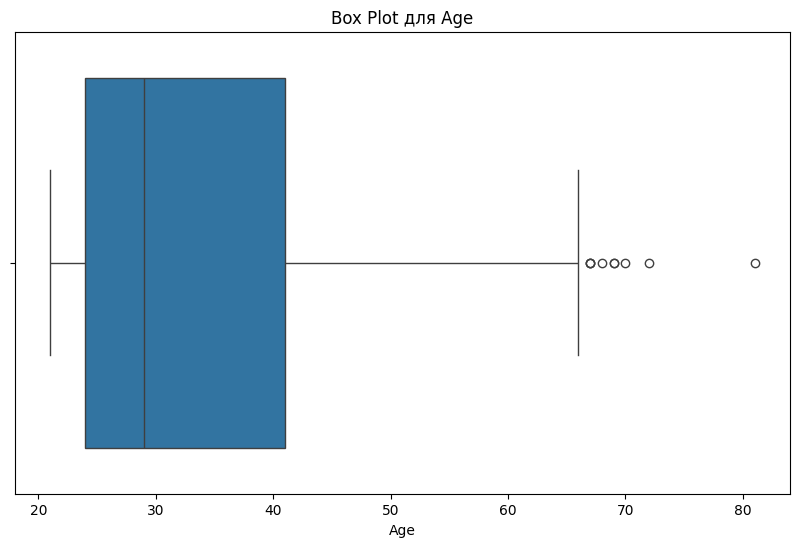

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot для столбца 'Popularity'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Age'])
plt.title('Box Plot для Age')
plt.xlabel('Age')
plt.show()

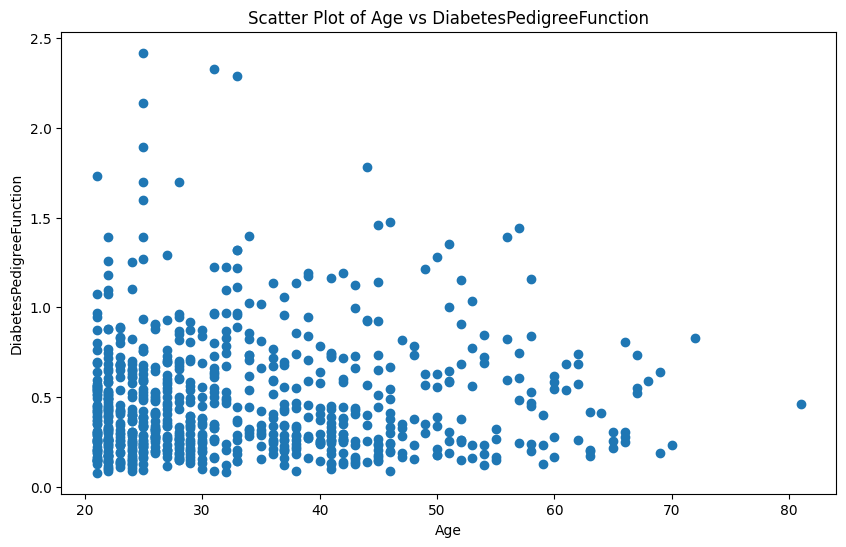

Выбросы:
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
4              0      137             40             35      168  43.1   
12            10      139             80              0        0  27.1   
39             4      111             72             47      207  37.1   
45             0      180             66             39        0  42.0   
58             0      146             82              0        0  40.5   
100            1      163             72              0        0  39.0   
147            2      106             64             35      119  30.5   
187            1      128             98             41       58  32.0   
218            5       85             74             22        0  29.0   
228            4      197             70             39      744  36.7   
243            6      119             50             22      176  27.1   
245            9      184             85             15        0  30.0   
259           11      155    

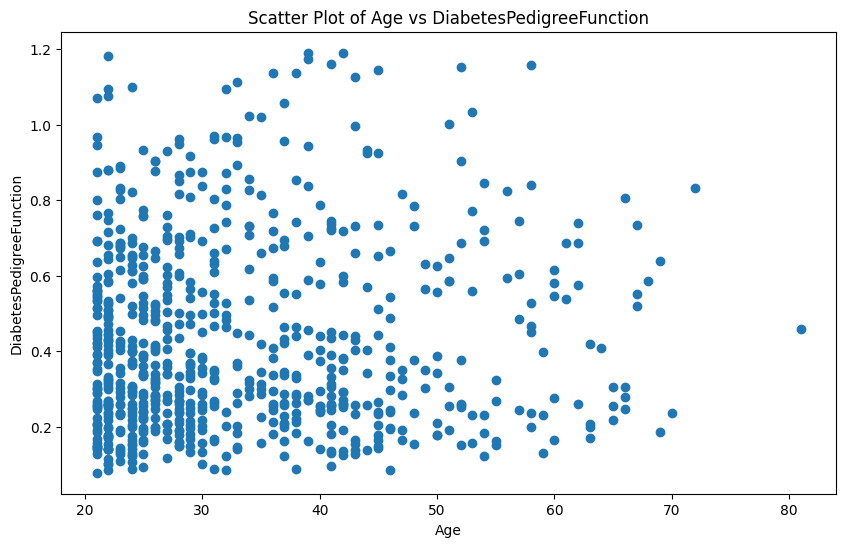

In [116]:
# Имеется смещение в меньшую сторону
df_cleaned = df.dropna()
plt.figure(figsize=(10, 6))
plt.scatter(df["Age"], df["DiabetesPedigreeFunction"])
plt.xlabel("Age")
plt.ylabel("DiabetesPedigreeFunction")
plt.title("Scatter Plot of Age vs DiabetesPedigreeFunction")
plt.show()

# уберем шумы

# Статистический анализ для определения выбросов
Q1 = df["DiabetesPedigreeFunction"].quantile(0.25)
Q3 = df["DiabetesPedigreeFunction"].quantile(0.75)
IQR = Q3 - Q1

# Определение порога для выбросов
threshold = 1.5 * IQR
outliers = (df["DiabetesPedigreeFunction"] < (Q1 - threshold)) | (
    df["DiabetesPedigreeFunction"] > (Q3 + threshold)
)

# Вывод выбросов
print("Выбросы:")
print(df[outliers])

# Обработка выбросов
# В данном случае мы уберем выбросы
median_charge = df["DiabetesPedigreeFunction"].median()
df.loc[outliers, "DiabetesPedigreeFunction"] = 0
df = df[df.DiabetesPedigreeFunction != 0]

# Визуализация данных после обработки
plt.figure(figsize=(10, 6))
plt.scatter(df["Age"], df["DiabetesPedigreeFunction"])
plt.xlabel("Age")
plt.ylabel("DiabetesPedigreeFunction")
plt.title("Scatter Plot of Age vs DiabetesPedigreeFunction")
plt.show()

Разбиение набора данных на обучающую, контрольную и тестовую выборки

In [117]:
from sklearn.model_selection import train_test_split

# Разделение на обучающую и тестовую выборки
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)

# Разделение обучающей выборки на обучающую и контрольную
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

print("Размер обучающей выборки:", len(train_df))
print("Размер контрольной выборки:", len(val_df))
print("Размер тестовой выборки:", len(test_df))

Размер обучающей выборки: 460
Размер контрольной выборки: 154
Размер тестовой выборки: 154


Видим недостаток баланса:

In [118]:
def check_balance(df, name):
    counts = df['Age'].value_counts()
    print(f"Распределение Age в {name}:")
    print(counts)
    print()

check_balance(train_df, "обучающей выборке")
check_balance(val_df, "контрольной выборке")
check_balance(test_df, "тестовой выборке")

Распределение Age в обучающей выборке:
Age
22    39
21    36
25    31
24    25
26    23
27    22
28    21
23    21
41    17
31    15
29    15
37    14
30    12
45    11
46    11
36    11
42    10
34    10
38    10
32     9
35     8
52     8
33     7
43     7
40     7
47     5
50     5
51     5
39     4
48     4
57     4
66     3
49     3
44     3
58     2
55     2
53     2
63     2
67     2
54     2
56     2
60     2
59     2
61     1
65     1
81     1
69     1
68     1
70     1
Name: count, dtype: int64

Распределение Age в контрольной выборке:
Age
22    20
21    15
24    11
23    10
25     9
33     8
26     7
31     6
30     5
28     5
27     5
39     4
29     4
42     4
40     4
32     3
37     2
46     2
51     2
44     2
34     2
43     2
41     2
45     2
54     2
35     2
58     1
53     1
61     1
59     1
64     1
36     1
50     1
72     1
49     1
47     1
66     1
62     1
69     1
55     1
Name: count, dtype: int64

Распределение Age в тестовой выборке:
Age
22    13
21    

Используем oversample

In [119]:
from imblearn.over_sampling import RandomOverSampler

def oversample(df):
    X = df.drop('Age', axis=1)
    y = df['Age']
    
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y) # type: ignore
    
    resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
    return resampled_df

train_df_oversampled = oversample(train_df)
val_df_oversampled = oversample(val_df)
test_df_oversampled = oversample(test_df)

check_balance(train_df_oversampled, "обучающей выборке после oversampling")
check_balance(val_df_oversampled, "контрольной выборке после oversampling")
check_balance(test_df_oversampled, "тестовой выборке после oversampling")

Распределение Age в обучающей выборке после oversampling:
Age
26    39
25    39
33    39
23    39
35    39
39    39
29    39
27    39
21    39
28    39
41    39
31    39
24    39
22    39
42    39
32    39
36    39
51    39
34    39
30    39
45    39
49    39
57    39
53    39
48    39
55    39
46    39
47    39
52    39
50    39
37    39
58    39
61    39
40    39
65    39
67    39
38    39
66    39
81    39
44    39
43    39
56    39
54    39
60    39
69    39
70    39
68    39
63    39
59    39
Name: count, dtype: int64

Распределение Age в контрольной выборке после oversampling:
Age
25    20
58    20
27    20
26    20
31    20
22    20
28    20
39    20
21    20
45    20
41    20
61    20
51    20
64    20
36    20
30    20
53    20
40    20
23    20
59    20
29    20
42    20
46    20
43    20
44    20
34    20
24    20
32    20
33    20
72    20
35    20
50    20
54    20
47    20
49    20
66    20
62    20
69    20
55    20
37    20
Name: count, dtype: int64

Распределение Age в

## Diamonds Prices2022

В данном наборе данных представлена цена на алмазы. Входные данные: цвет, вес (в каратах), цена, чистота, габариты. Цель: узнать, насколько дорого обходятся девушкам их друзья (Мэрилин Монро)

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv(".//static//csv//Diamonds Prices2022.csv")
print(df.columns)

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')


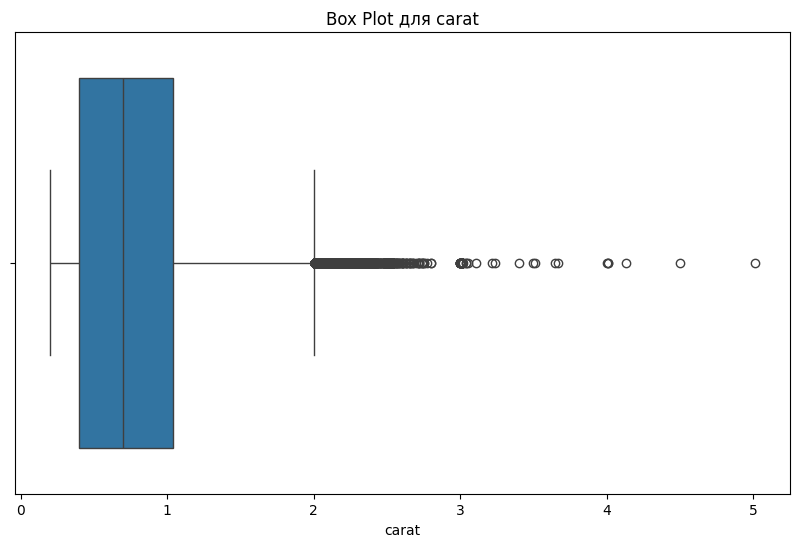

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.boxplot(x=df['carat'])
plt.title('Box Plot для carat')
plt.xlabel('carat')
plt.show()

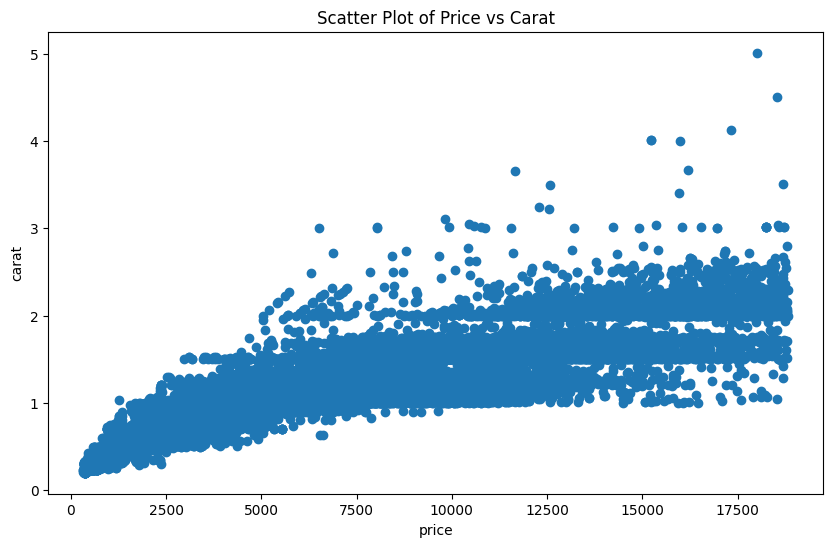

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns


# Визуализация данных после обработки
plt.figure(figsize=(10, 6))
plt.scatter(df["price"], df["carat"])
plt.xlabel("price")
plt.ylabel("carat")
plt.title("Scatter Plot of Price vs Carat")
plt.show()

Удаление строк с пустыми значениями

In [123]:
df_cleaned = df.dropna()

Разбиение набора данных на обучающую, контрольную и тестовую выборки

Применение методов приращения данных (аугментации)

In [124]:
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split

# Разделение на обучающую и тестовую выборки
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)

# Разделение обучающей выборки на обучающую и контрольную
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

print("Размер обучающей выборки:", len(train_df))
print("Размер контрольной выборки:", len(val_df))
print("Размер тестовой выборки:", len(test_df))

def check_balance(df, name):
    counts = df["price"].value_counts()
    print(f"Распределение price в {name}:")
    print(counts)
    print()


check_balance(train_df, "обучающей выборке")
check_balance(val_df, "контрольной выборке")
check_balance(test_df, "тестовой выборке")

def oversample(df):
    X = df.drop("price", axis=1)
    y = df["price"]

    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y) # type: ignore

    resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
    return resampled_df


train_df_oversampled = oversample(train_df)
val_df_oversampled = oversample(val_df)
test_df_oversampled = oversample(test_df)

check_balance(train_df_oversampled, "обучающей выборке после oversampling")
check_balance(val_df_oversampled, "контрольной выборке после oversampling")
check_balance(test_df_oversampled, "тестовой выборке после oversampling")

Размер обучающей выборки: 32365
Размер контрольной выборки: 10789
Размер тестовой выборки: 10789
Распределение price в обучающей выборке:
price
789      80
605      79
544      72
552      72
828      71
         ..
9942      1
7787      1
18663     1
7979      1
8164      1
Name: count, Length: 9496, dtype: int64

Распределение price в контрольной выборке:
price
625      34
828      31
605      30
789      26
544      26
         ..
4188      1
7541      1
3498      1
3314      1
12196     1
Name: count, Length: 5383, dtype: int64

Распределение price в тестовой выборке:
price
802     33
844     29
776     29
675     26
645     25
        ..
1567     1
5529     1
2031     1
417      1
5431     1
Name: count, Length: 5338, dtype: int64

Распределение price в обучающей выборке после oversampling:
price
5076    80
1789    80
3931    80
1263    80
2026    80
        ..
3678    80
4592    80
516     80
7152    80
2353    80
Name: count, Length: 9496, dtype: int64

Распределение price в кон

In [125]:
from imblearn.over_sampling import RandomOverSampler


def oversample(df):
    X = df.drop("price", axis=1)
    y = df["price"]

    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y) # type: ignore

    resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
    return resampled_df


train_df_oversampled = oversample(train_df)
val_df_oversampled = oversample(val_df)
test_df_oversampled = oversample(test_df)

check_balance(train_df_oversampled, "обучающей выборке после oversampling")
check_balance(val_df_oversampled, "контрольной выборке после oversampling")
check_balance(test_df_oversampled, "тестовой выборке после oversampling")

Распределение price в обучающей выборке после oversampling:
price
5076    80
1789    80
3931    80
1263    80
2026    80
        ..
3678    80
4592    80
516     80
7152    80
2353    80
Name: count, Length: 9496, dtype: int64

Распределение price в контрольной выборке после oversampling:
price
966      34
13638    34
3669     34
1052     34
2818     34
         ..
4032     34
544      34
3362     34
6559     34
792      34
Name: count, Length: 5383, dtype: int64

Распределение price в тестовой выборке после oversampling:
price
3742     33
559      33
8403     33
1238     33
1243     33
         ..
1149     33
2401     33
958      33
702      33
14618    33
Name: count, Length: 5338, dtype: int64

